In [1]:
import numpy as np
%matplotlib inline
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-whitegrid')
from sklearn import linear_model
plt.rcParams["figure.figsize"] = (16,8)
import math
from math import sqrt
from math import e as exp
import seaborn as sns
import statsmodels.api as sm
import random
from scipy import optimize
sns.set(rc={'figure.figsize':(2*11.7,2*8.27),"font.size":50,"axes.titlesize":30,"axes.labelsize":30},style="white", context='paper',font_scale=3)
import numba

from numba.experimental import jitclass


In [2]:
B = .10
D = 1e-3 #2.94e-8
lam =  2e-3   #3.833e-3
u = 1e7/60
V = 0.03 
boat_V = 1/3
T = 10*60
pf = 5/1000

In [80]:
#spec = [
#    ('V', float32),
#    ('u', float32),
#    ('λ', float32),
#    ('D', float32),
#    ('BV', float32),
#    ('T', float32),
#    ('B', float32),
#    ('pf', float32),
#]


#@jitclass(spec)
class River:
    def __init__(self):
        self.error = 0
        probfunction = pd.DataFrame([[-2,.333],[-1, .875],[0,1],[1,1], [-10,0], [-3,0]], columns=['initial eDNA', 'probability of amplification'])
        probfunction['copy number'] = probfunction['initial eDNA'].apply(lambda x: 10**x * 3.65*1e6)
        model2 = sm.Probit(probfunction['probability of amplification'].values, probfunction['copy number'].values)
        self.result2 = model2.fit()
        self.PofCaptureNet = 0.01

        
    def change_er(self,er):
        self.error = er
    
        
    def init_river_params(self, V,D,u,λ):
        self.V = V
        self.u = u
        self.λ = λ
        self.D = D
        if { 'V' , 'u' , 'λ' , 'D' , 'BV' , 'T' , 'pf' , 'B' } <= self.__dict__.keys():
            self.inf = -optimize.bisect (lambda x: self._solved_river_abv(0)*(0.025) -  self._solved_river_abv(x), 0, 1e10   )  
            self.sup = -optimize.bisect (lambda x: self._solved_river_bl(0)*(0.025) -  self._solved_river_bl(x), -1e10, 0  )  
    
    def init_sampling_strategy(self, pf, boat_V, time):
        self.pf = pf
        self.BV = boat_V
        self.T = time
        if { 'V' , 'u' , 'λ' , 'D' , 'BV' , 'T' , 'pf' , 'B' } <= self.__dict__.keys():
            self.inf = -optimize.bisect (lambda x: self._solved_river_abv(0)*(0.025) -  self._solved_river_abv(x), 0, 1e10   )  
            self.sup = -optimize.bisect (lambda x: self._solved_river_bl(0)*(0.025) -  self._solved_river_bl(x), -1e10, 0  ) #+ self.BV*self.T
        
    def init_fish(self, dist_bet_fish, biomass):
        self.B = biomass
        self.dist = dist_bet_fish
        if { 'V' , 'u' , 'λ' , 'D' , 'BV' , 'T' , 'pf' , 'B' } <= self.__dict__.keys():
            self.inf = -optimize.bisect (lambda x: self._solved_river_abv(0)*(0.025) -  self._solved_river_abv(x), 0, 1e10   )  
            self.sup = -optimize.bisect (lambda x: self._solved_river_bl(0)*(0.025) -  self._solved_river_bl(x), -1e10, 0  ) #+ self.BV*self.T
        
    def CtoP(self,c):
        return (self.result2.predict(c)-.5)/.5
        
    def CeDNA_1_Source(self,x):
        constants = (self.B*self.u)/(sqrt(self.V**2 + 4*self.D*self.λ))
        if x < 0: 
            result = constants * exp**(  (self.V+ sqrt(self.V**2 + 4*self.D*self.λ))*x / (2*self.D)  )
        else: 
            result = constants * exp**(  (self.V- sqrt(self.V**2 + 4*self.D*self.λ))*x / (2*self.D)  )
        if result < 1: return 0
        return result
    
    def fish_locations_transect(self):
        x = 0
        returnable = []
        while x > self.inf :
            a = -np.random.exponential(self.dist, 1)[0]
            x += a
            returnable += [x]
        returnable = returnable[::-1]
        x = 0        
        while x <  self.BV*self.T + self.sup:
            a = np.random.exponential(self.dist, 1)[0]
            x += a
            returnable += [x]
        return returnable

    def _fish_locations_net(self):
        ret = []
        x = 0
        while x< self.BV*self.T:
            x += np.random.exponential(self.dist, 1)[0]
            ret += [x]
        return ret[:-1]
            
    def average_catch(self, n = 1000):
        lis = np.array([sum([1 if random.random()< self.PofCaptureNet else 0 for x in self._fish_locations_net()]) for x in range(n)])
        return {'mean': lis.mean(), 'std': lis.std(), 'Prob_of_detection': 1 - (np.count_nonzero(lis)/len(lis)), 'list': lis}
    
    #@staticmethod
    def _solved_river_abv(self,x):
        return  -(self.pf/self.BV) *(2*self.B*self.u*self.D) /(4*self.D*self.λ - self.V*sqrt(self.V**2 + 4*self.D * self.λ)+ self.V**2)* exp**( (self.V - sqrt(self.V**2 + 4*self.D*self.λ))/ (2*self.D) * x )

    def _solved_river_bl(self,x):
        return  (self.pf/self.BV) *(2*self.B*self.u*self.D) /(4*self.D*self.λ + self.V*sqrt(self.V**2 + 4*self.D * self.λ)+ self.V**2) * exp**( (self.V + sqrt(self.V**2 + 4*self.D*self.λ))/ (2*self.D) * x )

    def _sld_intermediary(self,Xi, Xf):
        low, high = sorted([Xi, Xf])
        if low >= 0:
            return abs(self._solved_river_abv(Xf) - self._solved_river_abv(Xi))
        if high <= 0: 
            return abs(self._solved_river_bl(Xf) - self._solved_river_bl(Xi))

        return self._sld_intermediary(low, 0) + self._sld_intermediary(0, high)
    
    def sample_eDNA_transect(self,x0):
        ret = self._sld_intermediary(x0, x0 + self.BV*self.T)  + random.gauss(0, self.error)
        if ret< 0: return 0
        else: return ret
    
    def sample_eDNA_transect_n_sources(self):
        return np.array([self.sample_eDNA_transect( -dis )*(1+random.gauss(0, self.error))  for dis in self.fish_locations_transect()]).sum()
    
    
    def Sample_Multiple_Transects_With_Different_Fish_Distances(self, dist_range =  [0,100], n = 1000):
        store_dist = self.dist
        response = []
        if len(dist_range) == 2:
            distlist = [random.uniform(dist_range[0], dist_range[1]) for i in range(n)]
            
        else: distlist = dist_range
    
        for i in distlist:
            self.dist = i
            response += [self.sample_eDNA_transect_n_sources()]
        
        self.dist = store_dist
        response = self.CtoP(response)
        return {'distances': distlist, 'response': response, 'avg': np.array(response).mean(), 'std': np.array(response).std()}
    
    
    def Catch_Transects_With_Different_Fish_Distances(self, dist_range =  [0,100], n = 1000):
        store_dist = self.dist
        response = []
        distlist = [random.uniform(dist_range[0], dist_range[1]) for i in range(n)]

        if len(dist_range) == 2:
            distlist = [random.uniform(dist_range[0], dist_range[1]) for i in range(n)]
            
        else: distlist = dist_range
        
        for i in distlist:
            self.dist = i
            response += [self.average_catch(n=1)['mean']]
        
        self.dist = store_dist
        response = np.array(response)
        det_dist = np.array([1 if x> 0 else 0 for x in response])
        
        return {'distances': distlist, 'catch': response, 'detection': det_dist,'avg': response.mean(), 'std': response.std(), 'avg_detection': det_dist.mean(), 'std_detection': det_dist.std()}

    def Find_detection_range(self, p):
        max_up = optimize.bisect(lambda d: self.CtoP(self._sld_intermediary(-d, -d+self.BV*self.T))[0] - p, 0, 1e10)
        max_down = optimize.bisect(lambda d: self.CtoP(self._sld_intermediary(-d, -d+self.BV*self.T))[0] - p, -1e10, 0)
        return sorted([max_down, max_up])

    

In [4]:
river = River()
river.init_fish(dist_bet_fish = 50, biomass = .1)
river.init_river_params(V =0, D = 1e-3,u = 1e7/60 , λ = 2e-3)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17


# eDNA distribution

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17


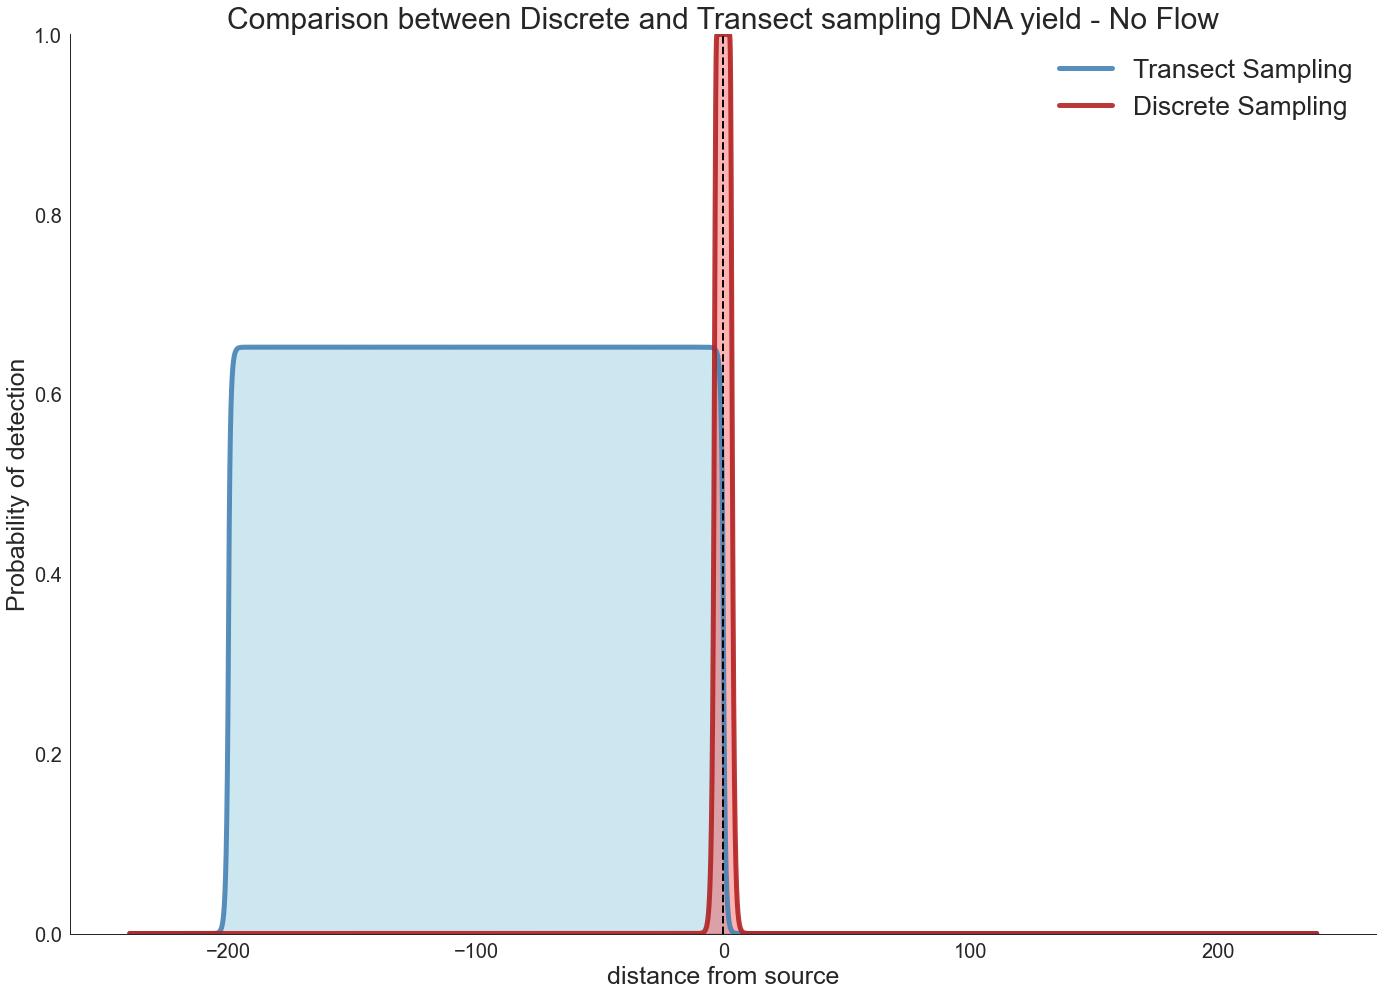

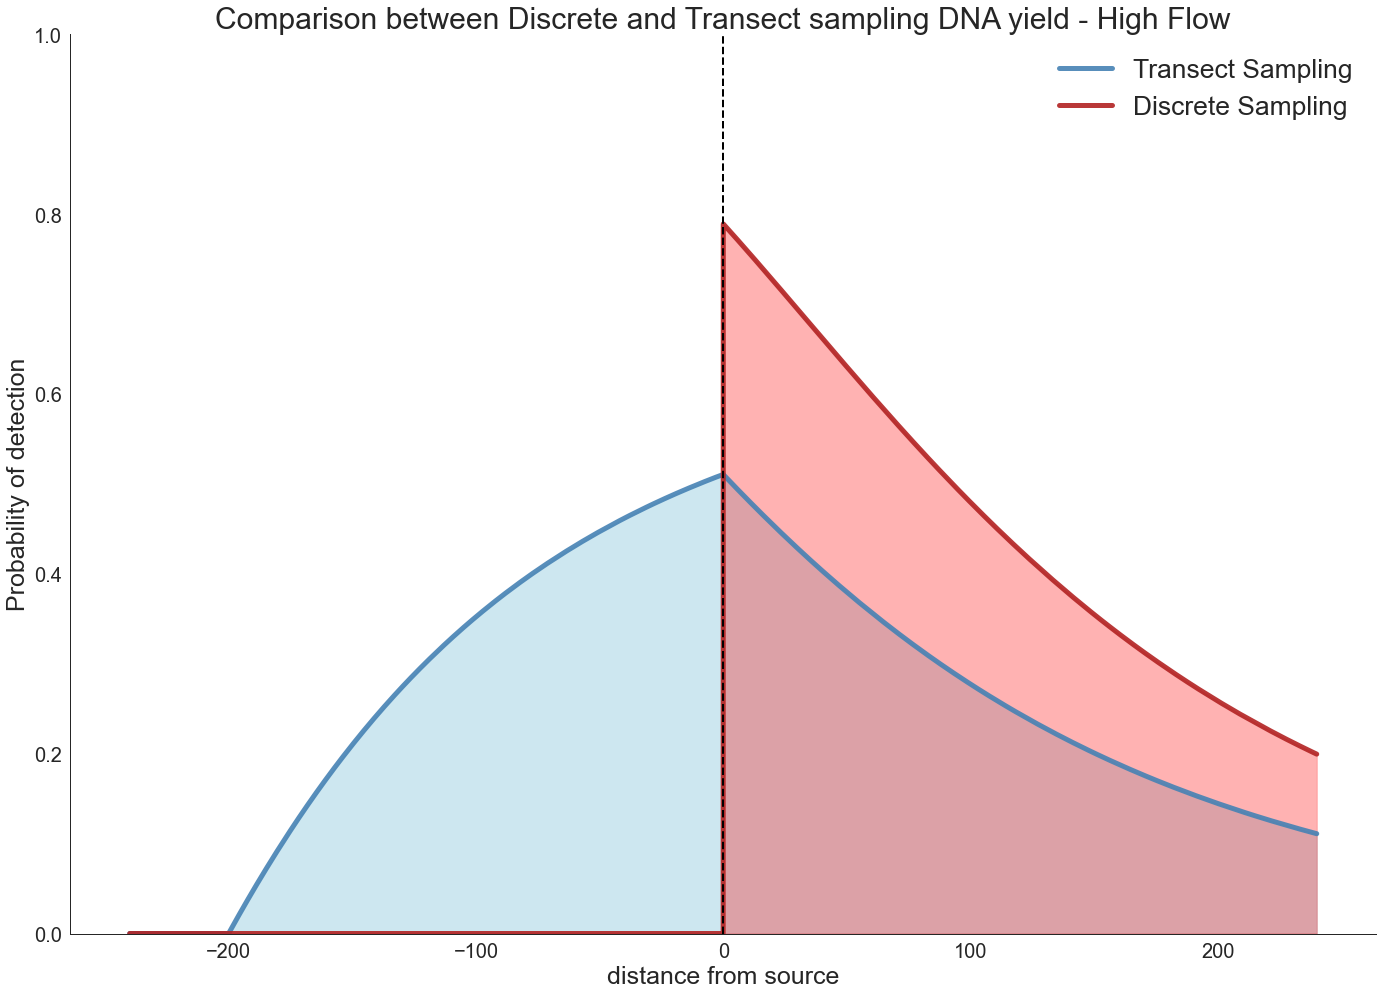

In [47]:
distlist = [random.random()*100 for i in range(1000)]
river = River()
river.init_fish(dist_bet_fish = 5, biomass = .1)
river.init_river_params(V =.0, D = 1e-3,u = 1e7/60 , λ = 2e-3)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.error = 1e-1

ranges = np.linspace(-240,240,10000)


river.BV = 1/3
transect = river.CtoP([river.sample_eDNA_transect(x) for x in ranges])

river.BV = 1e-6
discrete = river.CtoP([river.sample_eDNA_transect(x) for x in ranges])

plt.plot(ranges, transect, label = 'Transect Sampling', linewidth = 5, alpha = .9, color = 'steelblue')
plt.plot(ranges, discrete, label = 'Discrete Sampling', linewidth = 5, alpha = .9, color = 'firebrick')
plt.axvline(0, linestyle = '--', color = 'black', linewidth = 2)
sns.despine()
plt.ylim([0,1])

plt.legend(fontsize = 30, loc = 'upper left')#, title = 'Sampling mode'


plt.xlabel("distance from source",fontsize = 25)
plt.ylabel("Probability of detection",fontsize = 25) #x if x>1  else 1
plt.title('Comparison between Discrete and Transect sampling DNA yield - No Flow')

plt.fill_between(ranges,transect , 0, 
                 #where = (ranges > -250) & (ranges <= 300), 
                 color = 'lightblue', alpha = .6) 
plt.fill_between(ranges, discrete , 0, 
                 #where = (ranges > -250) & (ranges <= 300), 
                 color = 'red', alpha = .3) 

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend()
plt.show()


river.V = 0.3

river.BV = 1/3
transect = river.CtoP([river.sample_eDNA_transect(x) for x in ranges])

river.BV = 1e-6
discrete = river.CtoP([river.sample_eDNA_transect(x) for x in ranges])

plt.plot(ranges, transect, label = 'Transect Sampling', linewidth = 5, alpha = .9, color = 'steelblue')
plt.plot(ranges, discrete, label = 'Discrete Sampling', linewidth = 5, alpha = .9, color = 'firebrick')
plt.axvline(0, linestyle = '--', color = 'black', linewidth = 2)
sns.despine()
plt.ylim([0,1])

plt.legend(fontsize = 30, loc = 'upper left')#, title = 'Sampling mode'


plt.xlabel("distance from source",fontsize = 25)
plt.ylabel("Probability of detection",fontsize = 25) #x if x>1  else 1
plt.title('Comparison between Discrete and Transect sampling DNA yield - High Flow')

plt.fill_between(ranges,transect , 0, 
                 #where = (ranges > -250) & (ranges <= 300), 
                 color = 'lightblue', alpha = .6) 
plt.fill_between(ranges, discrete , 0, 
                 #where = (ranges > -250) & (ranges <= 300), 
                 color = 'red', alpha = .3) 

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend()
plt.show()


# testing figure 

In [6]:
distlist = [random.random()*100 for i in range(1000)]
river = River()
river.init_fish(dist_bet_fish = 5, biomass = .01)
river.init_river_params(V =10.0, D = 1e-3,u = 1e7/60 , λ = 2e-3)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.error = 1e-1

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17


CPU times: user 1min 2s, sys: 362 ms, total: 1min 2s
Wall time: 1min 2s


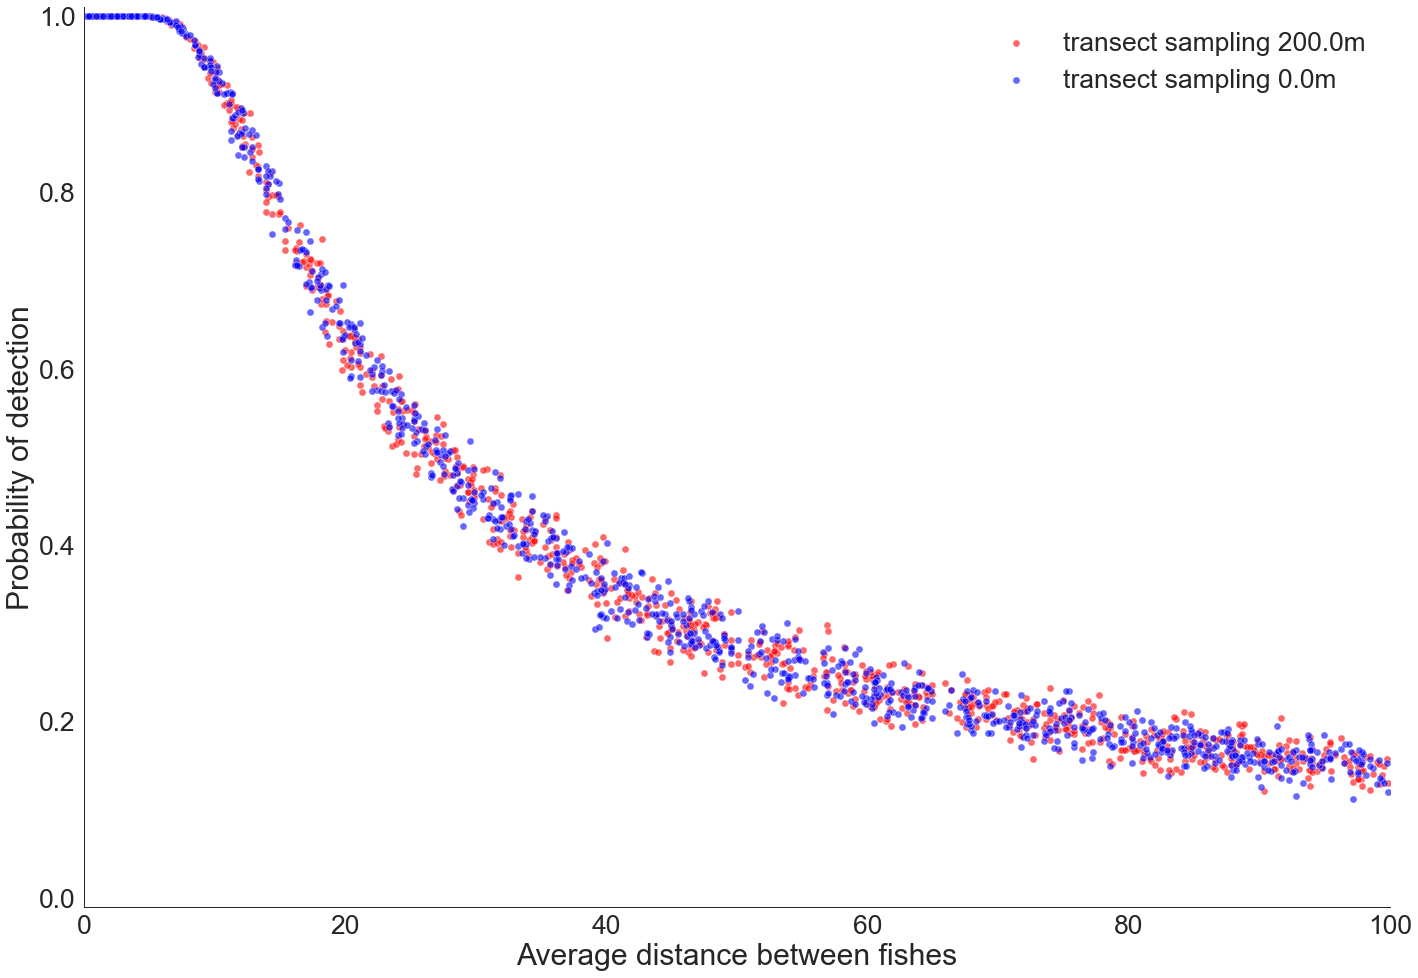

In [7]:
%%time
response = []
river.BV = 1/3
for i in distlist:
    river.dist = i
    response += [river.sample_eDNA_transect_n_sources()]
    
response = river.CtoP(response)
sns.scatterplot(x= distlist, y=response, s = 50, alpha = .6, color = 'red', label = 'transect sampling {:.1f}m'.format(river.BV*river.T))
#sns.lineplot(x= distlist, y=response, color = 'red', alpha = .3)
plt.legend(loc = 'best')

river.BV = 1e-5
response_disc = []
for i in distlist:
    river.dist = i
    response_disc += [river.sample_eDNA_transect_n_sources()]
    
response_disc = river.CtoP(response_disc)

sns.scatterplot(x= distlist, y=response_disc, s = 50, alpha = .6, color = 'blue', label = 'transect sampling {:.1f}m'.format(river.BV*river.T))
#sns.lineplot(x= distlist, y=response, color = 'blue', alpha = .3)
plt.ylabel('Probability of detection')
plt.xlabel('Average distance between fishes')
plt.ylim([-0.01,1.01])
plt.xlim([0,100])
plt.legend(loc = 'upper right')
sns.despine()

In [ ]:
%%time
response = []
river.BV = 1/3
for i in distlist:
    river.dist = i
    response += [river.sample_eDNA_transect_n_sources()]
    
response = river.CtoP(response)
sns.scatterplot(x= distlist, y=response, s = 50, alpha = .6, color = 'red', label = 'transect sampling {:.1f}m'.format(river.BV*river.T))
#sns.lineplot(x= distlist, y=response, color = 'red', alpha = .3)
plt.legend(loc = 'best')

river.BV = 1e-5
response_disc = []
for i in distlist:
    river.dist = i
    response_disc += [river.sample_eDNA_transect_n_sources()]
    
response_disc = river.CtoP(response_disc)

sns.scatterplot(x= distlist, y=response_disc, s = 50, alpha = .6, color = 'blue', label = 'transect sampling {:.1f}m'.format(river.BV*river.T))
#sns.lineplot(x= distlist, y=response, color = 'blue', alpha = .3)
plt.ylabel('Probability of detection')
plt.xlabel('Average distance between fishes')
plt.ylim([-0.01,1.01])
plt.xlim([0,100])
plt.legend(loc = 'upper right')
sns.despine()

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17
CPU times: user 542 ms, sys: 16.1 ms, total: 559 ms
Wall time: 540 ms
CPU times: user 175 ms, sys: 4.01 ms, total: 179 ms
Wall time: 166 ms
CPU times: user 260 ms, sys: 0 ns, total: 260 ms
Wall time: 260 ms
CPU times: user 47 ms, sys: 0 ns, total: 47 ms
Wall time: 47 ms


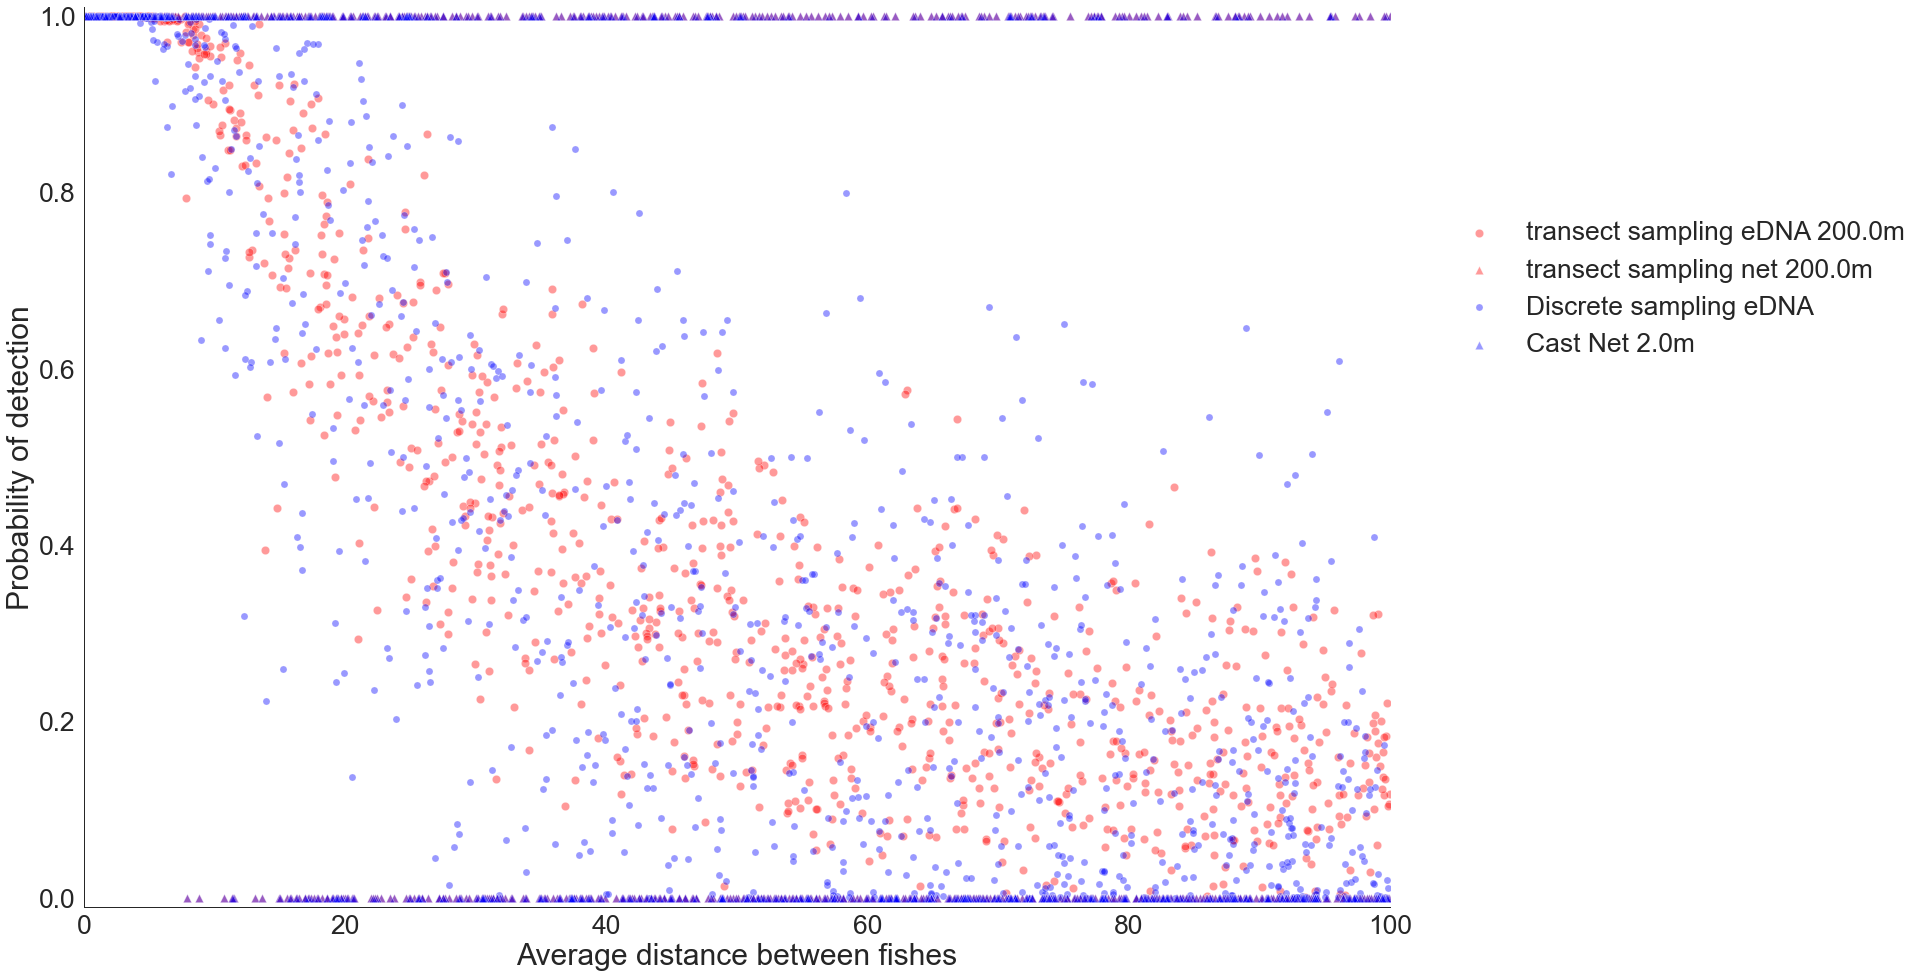

In [452]:
river = River()
river.init_fish(dist_bet_fish = 5, biomass = .01)
river.init_river_params(V =0.1, D = 1e-3,u = 1e7/60 , λ = 2e-3)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.error = 1e-1


%time edna_transect = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = [0,100], n = 1000)
%time net_transect = river.Catch_Transects_With_Different_Fish_Distances(dist_range = [0,100], n = 1000)

sns.scatterplot(x= edna_transect['distances'], y=edna_transect['response'], s = 70, alpha = .4, color = 'red', label = 'transect sampling eDNA {:.1f}m'.format(river.BV*river.T))
sns.scatterplot(x= net_transect['distances'], y=net_transect['detection'], s = 70, alpha = .4, color = 'red', label = 'transect sampling net {:.1f}m'.format(river.BV*river.T), marker = '^')

river.BV = 1e-5

%time edna = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = [0,100], n = 1000)
sns.scatterplot(x= edna['distances'], y=edna['response'], s = 50, alpha = .4, color = 'blue', label = 'Discrete sampling eDNA')


river.BV = 2/river.T

%time net = river.Catch_Transects_With_Different_Fish_Distances(dist_range = [0,100], n = 1000)
sns.scatterplot(x= net_transect['distances'], y=net_transect['detection'], s = 70, alpha = .4, color = 'blue', label = 'Cast Net {:.1f}m'.format(river.BV*river.T), marker = '^')


plt.legend(loc=(1.04,.6))


plt.ylabel('Probability of detection')
plt.xlabel('Average distance between fishes')
plt.ylim([-0.01,1.01])
plt.xlim([0,100])
#plt.legend(loc = 'upper right')
sns.despine()

In [526]:
def make_lis(rep = 700, init = 5, final = 100, n = 20):
    return np.array([[i for x in range(rep)] for i in np.linspace(init, final, n)]).flatten()


river = River()
river.init_fish(dist_bet_fish = 5, biomass = .01)
river.init_river_params(V =0., D = 1e-3,u = 1e7/60 , λ = 2e-3)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.error = 1e-1
river.PofCaptureNet = 0.01


%time edna_transect = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis())
df_et = pd.DataFrame(np.array([edna_transect['distances'], edna_transect['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_et['length'] =  'transect sampling {:.1f}m'.format(river.BV*river.T)
df_et['method'] = 'eDNA'

%time net_transect = river.Catch_Transects_With_Different_Fish_Distances(dist_range = make_lis())
df_nt = pd.DataFrame(np.array([net_transect['distances'], net_transect['detection']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])

df_nt['length'] =  'transect sampling {:.1f}m'.format(river.BV*river.T)
df_nt['method'] = 'net'

#sns.lineplot(x= edna_transect['distances'], y=edna_transect['response'],  alpha = .4, color = 'red', label = 'transect sampling eDNA {:.1f}m'.format(river.BV*river.T), markers=True, dashes=False)
#sns.lineplot(x= net_transect['distances'], y=net_transect['detection'], alpha = .4, color = 'red', label = 'transect sampling net {:.1f}m'.format(river.BV*river.T), linestyle = '--')

river.BV = 1e-5

%time edna = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis())

df_e = pd.DataFrame(np.array([edna['distances'], edna['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_e['length'] =  'discrete sampling' 
df_e['method'] = 'eDNA'

#sns.lineplot(x= edna['distances'], y=edna['response'], alpha = .4, color = 'blue', label = 'Discrete sampling eDNA')


river.BV = 2/river.T

%time net = river.Catch_Transects_With_Different_Fish_Distances(dist_range = make_lis())
#sns.lineplot(x= net['distances'], y=net['detection'],alpha = .4, color = 'blue', label = 'Cast Net {:.1f}m'.format(river.BV*river.T), linestyle = '--')
df_n = pd.DataFrame(np.array([net['distances'], net['detection']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_n['length'] =  'cast net {:.1f}m'.format(river.BV*river.T)
df_n['method'] = 'net'

all_df = pd.concat([df_et,df_nt, df_e, df_n],ignore_index=True)
all_df.head(2)

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17
CPU times: user 2.76 s, sys: 24.2 ms, total: 2.79 s
Wall time: 2.76 s
CPU times: user 1.39 s, sys: 169 ms, total: 1.56 s
Wall time: 1.33 s
CPU times: user 852 ms, sys: 12.3 ms, total: 865 ms
Wall time: 839 ms
CPU times: user 835 ms, sys: 108 ms, total: 943 ms
Wall time: 758 ms


,distances,Probability of detection,length,method
0,5.0,0.999843,transect sampling 200.0m,eDNA
1,5.0,0.999385,transect sampling 200.0m,eDNA


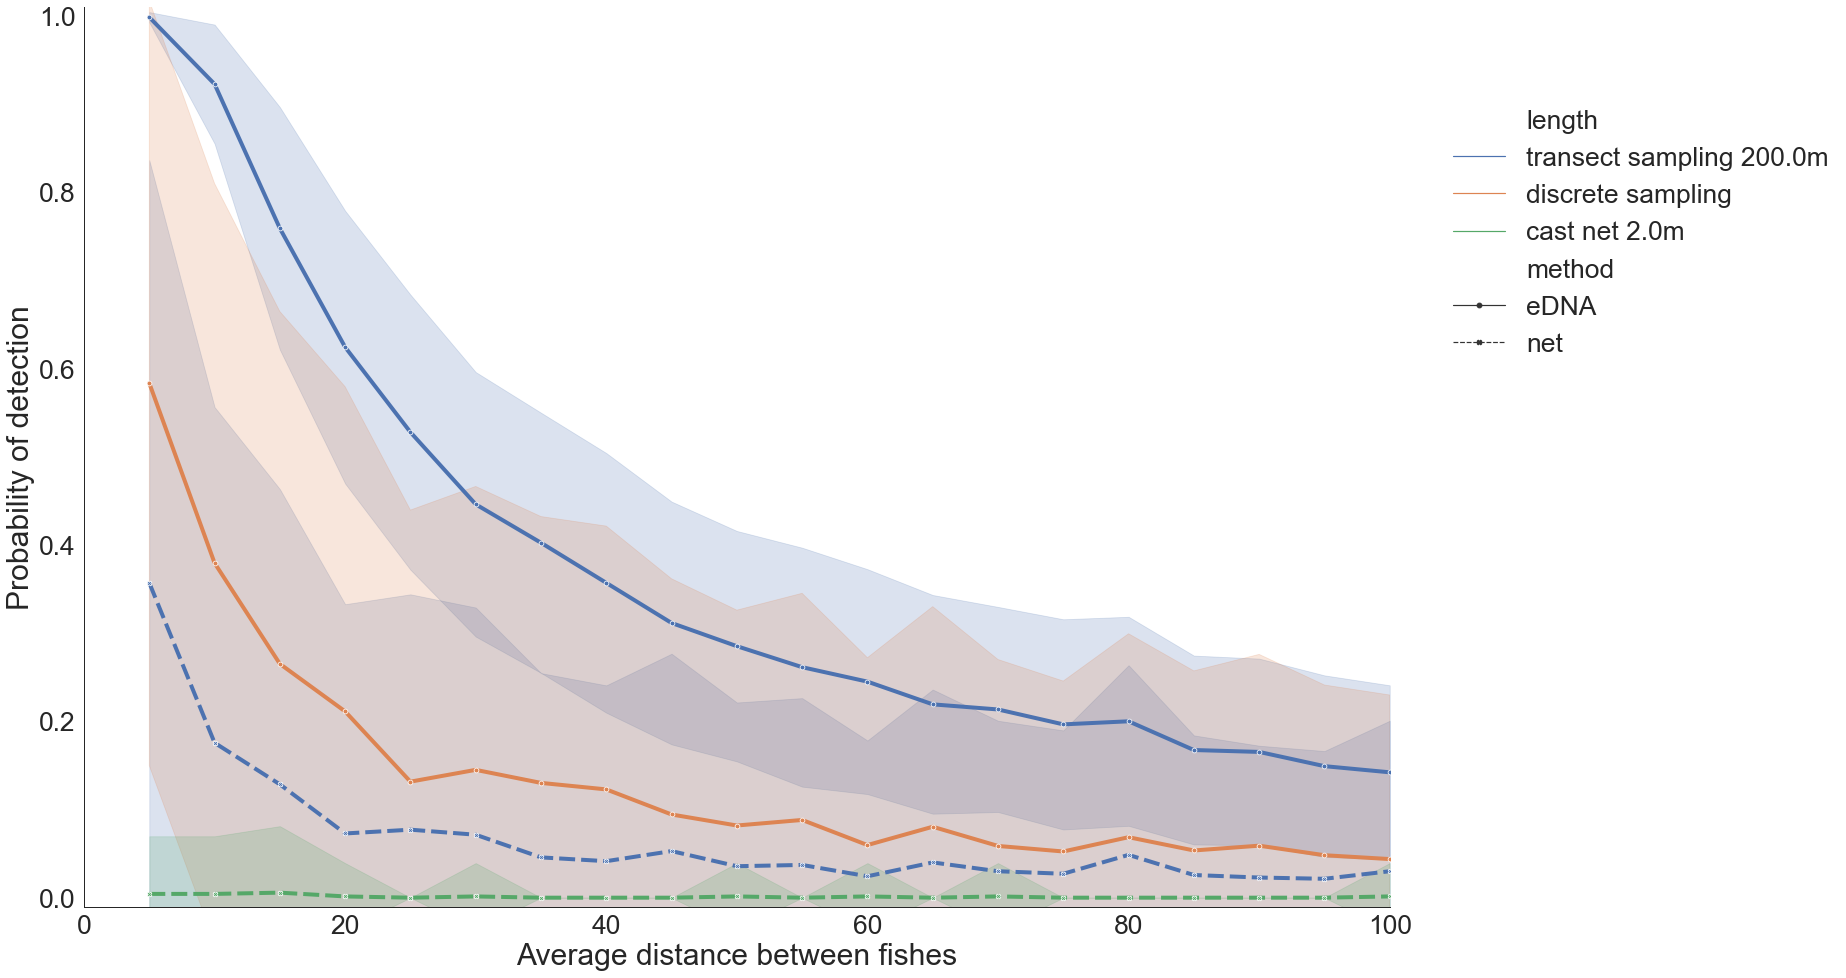

In [527]:
sns.lineplot(data = all_df, x = 'distances', y = 'Probability of detection', hue="length", style="method",
    markers=True, dashes=True, sizes = 20, linewidth = 4, ci = 'sd')
sns.despine()
plt.ylabel('Probability of detection')
plt.xlabel('Average distance between fishes')
plt.ylim([-0.01,1.01])
plt.xlim([0,100])
plt.legend(loc=(1.04,.6))
sns.despine()

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17
CPU times: user 1min 52s, sys: 231 ms, total: 1min 52s
Wall time: 1min 52s
CPU times: user 1.43 s, sys: 185 ms, total: 1.61 s
Wall time: 1.35 s
CPU times: user 1min 50s, sys: 192 ms, total: 1min 50s
Wall time: 1min 50s
CPU times: user 1 s, sys: 169 ms, total: 1.17 s
Wall time: 842 ms


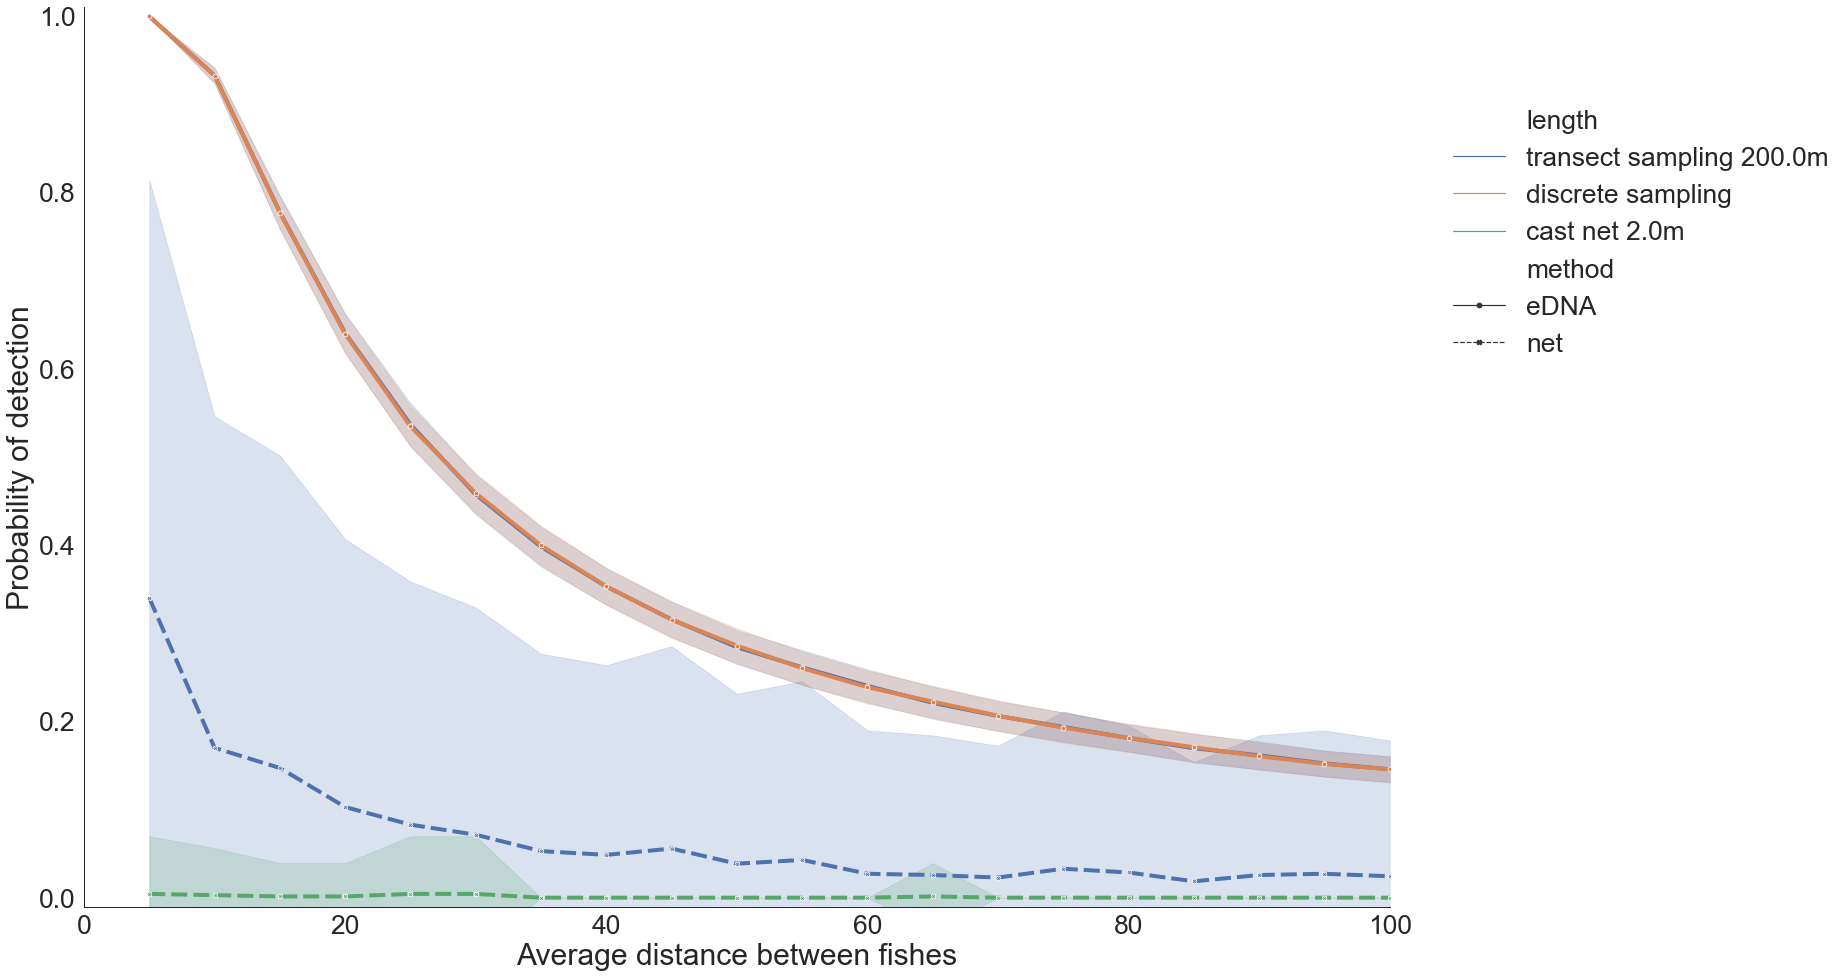

In [528]:
def make_lis(rep = 700, init = 5, final = 100, n = 20):
    return np.array([[i for x in range(rep)] for i in np.linspace(init, final, n)]).flatten()


river = River()
river.init_fish(dist_bet_fish = 5, biomass = .01)
river.init_river_params(V =10., D = 1e-3,u = 1e7/60 , λ = 2e-3)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.error = 1e-1
river.PofCaptureNet = 0.01


%time edna_transect = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis())
df_et = pd.DataFrame(np.array([edna_transect['distances'], edna_transect['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_et['length'] =  'transect sampling {:.1f}m'.format(river.BV*river.T)
df_et['method'] = 'eDNA'

%time net_transect = river.Catch_Transects_With_Different_Fish_Distances(dist_range = make_lis())
df_nt = pd.DataFrame(np.array([net_transect['distances'], net_transect['detection']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])

df_nt['length'] =  'transect sampling {:.1f}m'.format(river.BV*river.T)
df_nt['method'] = 'net'

#sns.lineplot(x= edna_transect['distances'], y=edna_transect['response'],  alpha = .4, color = 'red', label = 'transect sampling eDNA {:.1f}m'.format(river.BV*river.T), markers=True, dashes=False)
#sns.lineplot(x= net_transect['distances'], y=net_transect['detection'], alpha = .4, color = 'red', label = 'transect sampling net {:.1f}m'.format(river.BV*river.T), linestyle = '--')

river.BV = 1e-5

%time edna = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis())

df_e = pd.DataFrame(np.array([edna['distances'], edna['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_e['length'] =  'discrete sampling' 
df_e['method'] = 'eDNA'

#sns.lineplot(x= edna['distances'], y=edna['response'], alpha = .4, color = 'blue', label = 'Discrete sampling eDNA')


river.BV = 2/river.T

%time net = river.Catch_Transects_With_Different_Fish_Distances(dist_range = make_lis())
#sns.lineplot(x= net['distances'], y=net['detection'],alpha = .4, color = 'blue', label = 'Cast Net {:.1f}m'.format(river.BV*river.T), linestyle = '--')
df_n = pd.DataFrame(np.array([net['distances'], net['detection']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_n['length'] =  'cast net {:.1f}m'.format(river.BV*river.T)
df_n['method'] = 'net'

all_df = pd.concat([df_et,df_nt, df_e, df_n],ignore_index=True)
all_df.head(2)


sns.lineplot(data = all_df, x = 'distances', y = 'Probability of detection', hue="length", style="method",
    markers=True, dashes=True, sizes = 20, linewidth = 4, ci = 'sd')
sns.despine()
plt.ylabel('Probability of detection')
plt.xlabel('Average distance between fishes')
plt.ylim([-0.01,1.01])
plt.xlim([0,100])
plt.legend(loc=(1.04,.6))
sns.despine()

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17
CPU times: user 2.71 s, sys: 23.7 ms, total: 2.73 s
Wall time: 2.73 s
CPU times: user 1.39 s, sys: 145 ms, total: 1.54 s
Wall time: 1.28 s
CPU times: user 624 ms, sys: 24 ms, total: 648 ms
Wall time: 603 ms
CPU times: user 867 ms, sys: 121 ms, total: 988 ms
Wall time: 833 ms


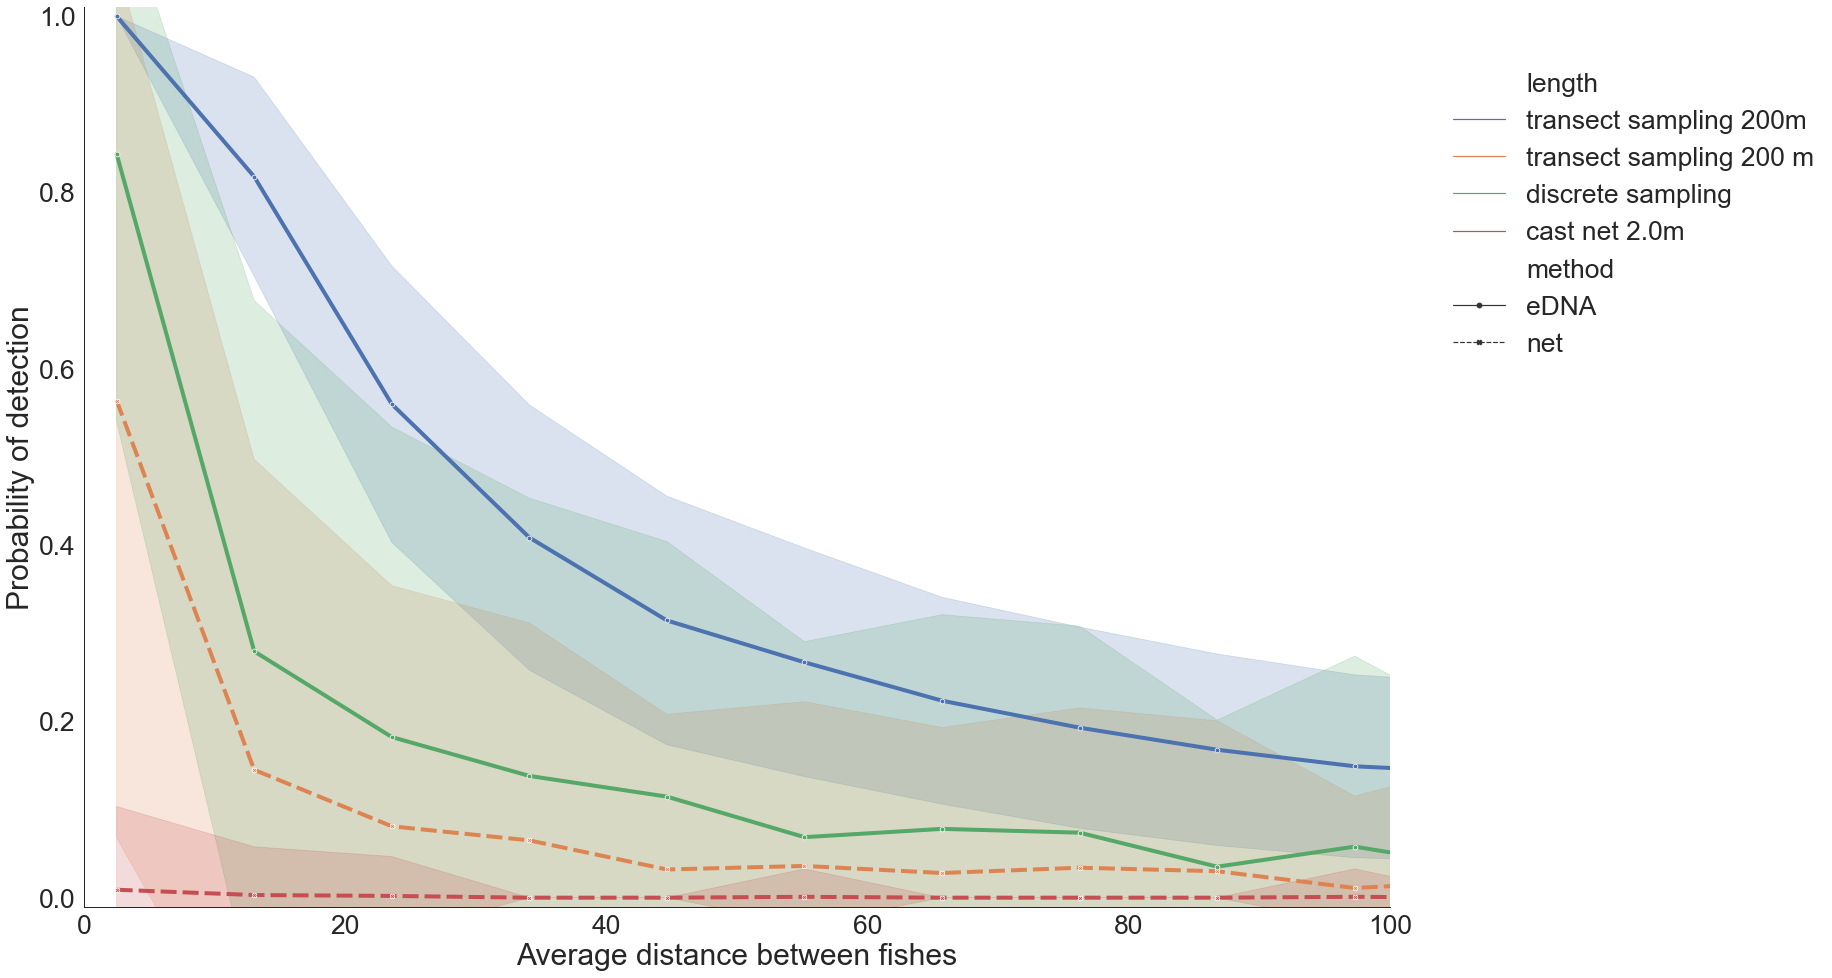

In [557]:
def make_lis(rep = 1000, init = 2.5, final = 150, n = 15):
    return np.array([[i for x in range(rep)] for i in np.linspace(init, final, n)]).flatten()


river = River()
river.init_fish(dist_bet_fish = 5, biomass = .01)
river.init_river_params(V =1e-5, D = 1e-3,u = 1e7/60 , λ = 2e-3)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.error = 1e-1
river.PofCaptureNet = 0.01


%time edna_transect = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis())
df_et = pd.DataFrame(np.array([edna_transect['distances'], edna_transect['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_et['length'] =  'transect sampling {:.0f}m'.format(river.BV*river.T)
df_et['method'] = 'eDNA'

%time net_transect = river.Catch_Transects_With_Different_Fish_Distances(dist_range = make_lis())
df_nt = pd.DataFrame(np.array([net_transect['distances'], net_transect['detection']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])

df_nt['length'] =  'transect sampling {:.0f} m'.format(river.BV*river.T)
df_nt['method'] = 'net'

#sns.lineplot(x= edna_transect['distances'], y=edna_transect['response'],  alpha = .4, color = 'red', label = 'transect sampling eDNA {:.1f}m'.format(river.BV*river.T), markers=True, dashes=False)
#sns.lineplot(x= net_transect['distances'], y=net_transect['detection'], alpha = .4, color = 'red', label = 'transect sampling net {:.1f}m'.format(river.BV*river.T), linestyle = '--')

river.BV = 1e-5

%time edna = river.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis())

df_e = pd.DataFrame(np.array([edna['distances'], edna['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_e['length'] =  'discrete sampling' 
df_e['method'] = 'eDNA'

#sns.lineplot(x= edna['distances'], y=edna['response'], alpha = .4, color = 'blue', label = 'Discrete sampling eDNA')


river.BV = 2/river.T

%time net = river.Catch_Transects_With_Different_Fish_Distances(dist_range = make_lis())
#sns.lineplot(x= net['distances'], y=net['detection'],alpha = .4, color = 'blue', label = 'Cast Net {:.1f}m'.format(river.BV*river.T), linestyle = '--')
df_n = pd.DataFrame(np.array([net['distances'], net['detection']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
df_n['length'] =  'cast net {:.1f}m'.format(river.BV*river.T)
df_n['method'] = 'net'

all_df = pd.concat([df_et,df_nt, df_e, df_n],ignore_index=True)
all_df.head(2)


sns.lineplot(data = all_df, x = 'distances', y = 'Probability of detection', hue="length", style="method",
    markers=True, dashes=True, sizes = 20, linewidth = 4, ci = 'sd')
sns.despine()
plt.ylabel('Probability of detection')
plt.xlabel('Average distance between fishes')
plt.ylim([-0.01,1.01])
plt.xlim([0,100])
sns.despine()
#sns.scatterplot(x = 'distances', y = 'Probability of detection', hue="length", linewidth=0,     data=all_df, alpha = .01)
plt.legend(loc=(1.04,.6))


In [14]:
%%time
from ipywidgets import interact, interact_manual, interactive,interactive_output, Layout
import ipywidgets as widgets
def make_lis(rep = 1000, init = 2.5, final = 200, n = 50):
    return np.array([[i for x in range(rep)] for i in np.linspace(init, final, n)]).flatten()



@interact_manual(
                 biomass_of_fish_cluster = widgets.FloatSlider(value=.05, min=0.01, max=.1, step=0.01, continuous_update=False, orientation='horizontal', readout=True, readout_format='.3f'),
                 river_velocity = widgets.FloatSlider(value=0.001, min=0.00001, max=1, step=0.1, continuous_update=False, orientation='horizontal', readout=True, readout_format='.1f'),
                 diffusion = widgets.FloatSlider(value=1e-3, min=1e-4, max=1e-2, step=1e-4,  continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 degradation = widgets.FloatSlider(value=2e-3, min=1e-4, max=1e-2, step=1e-4, continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 eDNA_production_rate = widgets.FloatSlider(value=1e7/60, min=1e6/60, max=1e8/60, step=1e6/60, continuous_update=False, orientation='horizontal', readout=True, readout_format='.0f'),
                 boat_velocity = widgets.FloatSlider(value=1/3, min=1e-5, max=3, step=0.1,continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 transect_duration = widgets.FloatSlider(value=600, min=6, max=6000, step=1,  continuous_update=False, orientation='horizontal', readout=True, readout_format='.0f'),
                 pump_flow = widgets.FloatSlider(value=5*1e-3, min=5*1e-4, max=5*1e-2, step=5*1e-4, continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 probability_of_capture = widgets.FloatSlider(value=0.05, min=0.00001, max=1, step=0.01, continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                )
def plot(biomass_of_fish_cluster, river_velocity, diffusion,degradation, eDNA_production_rate ,boat_velocity, transect_duration,pump_flow, probability_of_capture ):

    river2 = River()
    river2.init_fish(dist_bet_fish = 10, biomass = biomass_of_fish_cluster)
    river2.init_river_params(V =river_velocity, D = diffusion,u = eDNA_production_rate , λ = degradation)
    river2.init_sampling_strategy(pf= pump_flow, boat_V= boat_velocity, time = transect_duration)
    river2.error = 1e-1
    river2.PofCaptureNet = 0.05


    edna_transect2 = river2.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis())
    df_et2 = pd.DataFrame(np.array([edna_transect2['distances'], edna_transect2['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
    df_et2['length'] =  'eDNA transect sampling {:.0f}m'.format(river2.BV*river2.T)
    df_et2['method'] = 'eDNA'

    net_transect2 = river2.Catch_Transects_With_Different_Fish_Distances(dist_range = make_lis())
    df_nt2 = pd.DataFrame(np.array([net_transect2['distances'], net_transect2['detection']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])

    df_nt2['length'] =  'net transect sampling {:.0f}m'.format(river2.BV*river2.T)
    df_nt2['method'] = 'net'

    #sns.lineplot(x= edna_transect['distances'], y=edna_transect['response'],  alpha = .4, color = 'red', label = 'transect sampling eDNA {:.1f}m'.format(river.BV*river.T), markers=True, dashes=False)
    #sns.lineplot(x= net_transect['distances'], y=net_transect['detection'], alpha = .4, color = 'red', label = 'transect sampling net {:.1f}m'.format(river.BV*river.T), linestyle = '--')

    river2.BV = 1e-5

    edna2 = river2.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis())

    df_e2 = pd.DataFrame(np.array([edna2['distances'], edna2['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
    df_e2['length'] =  'discrete sampling' 
    df_e2['method'] = 'eDNA'

    #sns.lineplot(x= edna['distances'], y=edna['response'], alpha = .4, color = 'blue', label = 'Discrete sampling eDNA')


    river2.BV = 2/river2.T

    net2 = river2.Catch_Transects_With_Different_Fish_Distances(dist_range = make_lis())
    #sns.lineplot(x= net['distances'], y=net['detection'],alpha = .4, color = 'blue', label = 'Cast Net {:.1f}m'.format(river.BV*river.T), linestyle = '--')
    df_n2 = pd.DataFrame(np.array([net2['distances'], net2['detection']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
    df_n2['length'] =  'cast net {:.1f}m'.format(river2.BV*river2.T)
    df_n2['method'] = 'net'

    all_df2 = pd.concat([df_et2,df_nt2, df_e2, df_n2],ignore_index=True)
    all_df2.head(2)


    sns.lineplot(data = all_df2, x = 'distances', y = 'Probability of detection', hue="length", style="method",
        markers=True, dashes=True, sizes = 20, linewidth = 4) #, ci = 'sd'
    sns.despine()
    plt.ylabel('Probability of detection')
    plt.xlabel('Average distance between fishes')
    plt.ylim([-0.01,1.01])
    plt.xlim([0,200])
    sns.despine()
    #sns.scatterplot(x = 'distances', y = 'Probability of detection', hue="length", linewidth=0, data=all_df2, alpha = .01)
    plt.legend(loc=(1.04,.6))


interactive(children=(FloatSlider(value=0.05, continuous_update=False, description='biomass_of_fish_cluster', …

CPU times: user 90 ms, sys: 140 µs, total: 90.1 ms
Wall time: 101 ms


In [570]:
str(11)

'11'

In [13]:
from ipywidgets import interact, interact_manual, interactive,interactive_output, Layout
import ipywidgets as widgets
def make_lis(rep = 100, init = 2.5, final = 150, n = 100):
    return np.array([[i for x in range(rep)] for i in np.linspace(init, final, n)]).flatten()



@interact_manual(
                 biomass_of_fish_cluster = widgets.FloatSlider(value=.03, min=0.01, max=.1, step=0.01, continuous_update=False, orientation='horizontal', readout=True, readout_format='.3f'),
                 river_velocity = widgets.FloatSlider(value=0.001, min=0.00001, max=1, step=0.1, continuous_update=False, orientation='horizontal', readout=True, readout_format='.1f'),
                 diffusion = widgets.FloatSlider(value=1e-3, min=1e-4, max=1e-2, step=1e-4,  continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 degradation = widgets.FloatSlider(value=2e-3, min=1e-4, max=1e-2, step=1e-4, continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 eDNA_production_rate = widgets.FloatSlider(value=1e7/60, min=1e6/60, max=1e8/60, step=1e6/60, continuous_update=False, orientation='horizontal', readout=True, readout_format='.0f'),
                 #boat_velocity = widgets.FloatSlider(value=1/3, min=1e-5, max=3, step=0.1,continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 transect_duration = widgets.FloatSlider(value=600, min=6, max=6000, step=1,  continuous_update=False, orientation='horizontal', readout=True, readout_format='.0f'),
                 pump_flow = widgets.FloatSlider(value=5*1e-3, min=5*1e-4, max=5*1e-2, step=5*1e-4, continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                 #probability_of_capture = widgets.FloatSlider(value=0.05, min=0.00001, max=1, step=0.01, continuous_update=False, orientation='horizontal', readout=True, readout_format='.6f'),
                )
def plot(biomass_of_fish_cluster, river_velocity, diffusion,degradation, eDNA_production_rate , transect_duration,pump_flow ):
    river2 = River()
    river2.init_fish(dist_bet_fish = 10, biomass = biomass_of_fish_cluster)
    river2.init_river_params(V =river_velocity, D = diffusion,u = eDNA_production_rate , λ = degradation)
    river2.init_sampling_strategy(pf= pump_flow, boat_V= 1, time = transect_duration)
    river2.error = 1e-1
    river2.PofCaptureNet = 0.05
    
    df_lis = []
    
    for boatV in np.array([1e-5, 1,5,10, 25, 50, 100, 250, 500,1000])/river2.T: #np.logspace(-5, 1, num = 15):
        river2.init_sampling_strategy(pf= pump_flow, boat_V= boatV, time = transect_duration)
        edna_transect2 = river2.Sample_Multiple_Transects_With_Different_Fish_Distances(dist_range = make_lis(rep = 800,final = 300 ,n = 50))
        df_et2 = pd.DataFrame(np.array([edna_transect2['distances'], edna_transect2['response']]).T, columns= ['distances', 'Probability of detection']).sort_values(by=['distances'])
        df_et2['length'] =  '{:.0f}m'.format(river2.BV*river2.T)
        df_lis += [df_et2]
        
    dfp = pd.concat(df_lis)
    sns.despine()
    sns.lineplot(data = dfp, x = 'distances', y = 'Probability of detection', hue="length", linewidth = .5, alpha = .6, palette = 'coolwarm' )
    plt.ylabel('Probability of detection')
    plt.xlabel('Average distance between fishes')
    plt.ylim([-0.01,1.01])
    plt.xlim([0,300])
    sns.despine()
    plt.title ('Fish weight: {:.0f}g/Fish; Advection {:.2f}m/s; Sampled Volume {:.0f}L'.format(river2.B*1000, river2.V, river2.pf*river2.T))
    plt.legend(loc=(1.01,.25), title = 'eDNA transect\nsampling distance')
    


interactive(children=(FloatSlider(value=0.03, continuous_update=False, description='biomass_of_fish_cluster', …

## where are the fishes at??


In [78]:
river.BV

1e-05

In [100]:
river = River()
river.init_fish(dist_bet_fish = 5, biomass = .01)
river.init_river_params(V =1e-5, D = 1e-3,u = 1e7/60 , λ = 2e-3)
river.init_sampling_strategy(pf= 5*1e-3, boat_V= 1/3, time = 10*60)
river.error = 1e-1
river.PofCaptureNet = 0.01

Optimization terminated successfully.
         Current function value: 0.366233
         Iterations 17


In [83]:
from itertools import product

In [147]:
sma = []
bv_space = np.linspace(1e-4, .5, 5) # np.array([1e-5, 0.05, .5])
rivV_space =  np.linspace(1e-4, .5,  5) #np.array([1e-5, .1, .3])
for bv,V in product(bv_space, rivV_space):
    river.init_river_params(V =V, D = 1e-3,u = 1e7/60 , λ = 2e-3)
    river.init_sampling_strategy(pf= 5*1e-3, boat_V= bv, time = 10*60)
    down, up = river.Find_detection_range(0.025)
    sma += [[V, bv, up, down]]
    #sma += [[V, bv, river.sup + river.BV*river.T, river.inf]]
lg =pd.DataFrame(sma, columns = ['Advection', 'Boat speed', 'sup', 'inf'])
lg['group'] = lg.apply(lambda row: 'Adv: {:.2f}; Boat_V: {:.2f}'.format(row['Advection'], row['Boat speed']), axis = 1)
lg['space'] = lg.apply(lambda row: list(range(int(row['inf']), int(row['sup']))), axis = 1)
lg['length'] = lg.sup -lg.inf
lg = lg.sort_values(['Advection', 'Boat speed'], ascending = False)

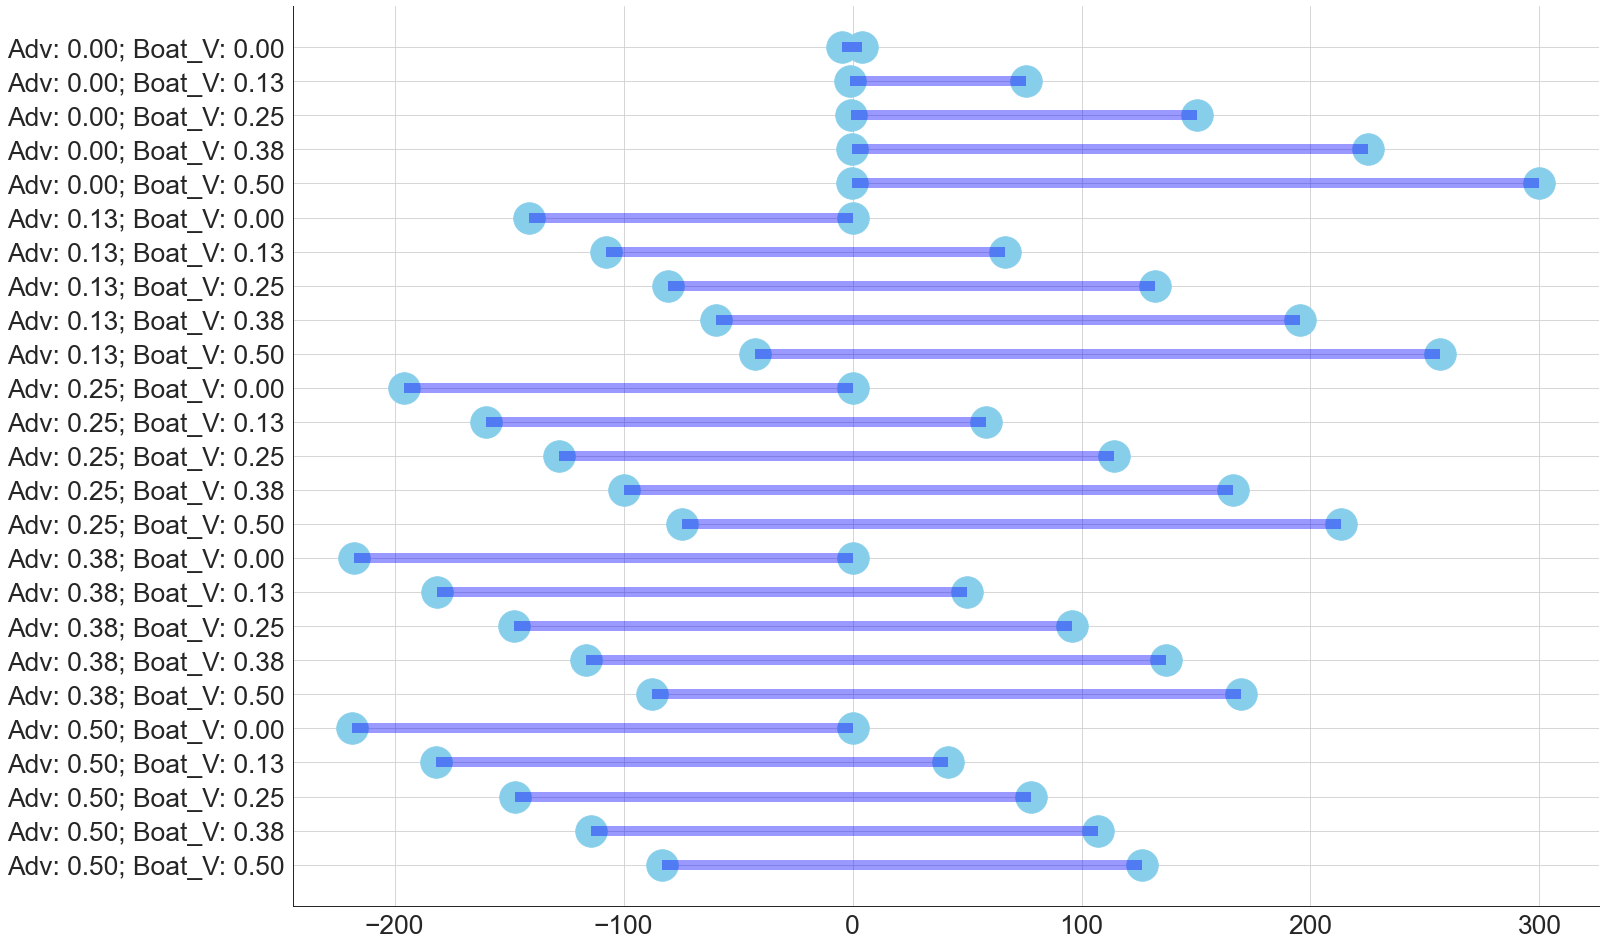

In [148]:
plt.hlines(y='group', xmin='inf', xmax='sup', color='blue', alpha=0.4, data = lg,linewidth =10)
plt.scatter(x = 'inf', y = 'group', color='skyblue', alpha=1, data = lg, s= 1000)
plt.scatter(x = 'sup', y = 'group', color='skyblue', alpha=1, data = lg,s= 1000)
sns.despine()
plt.grid()

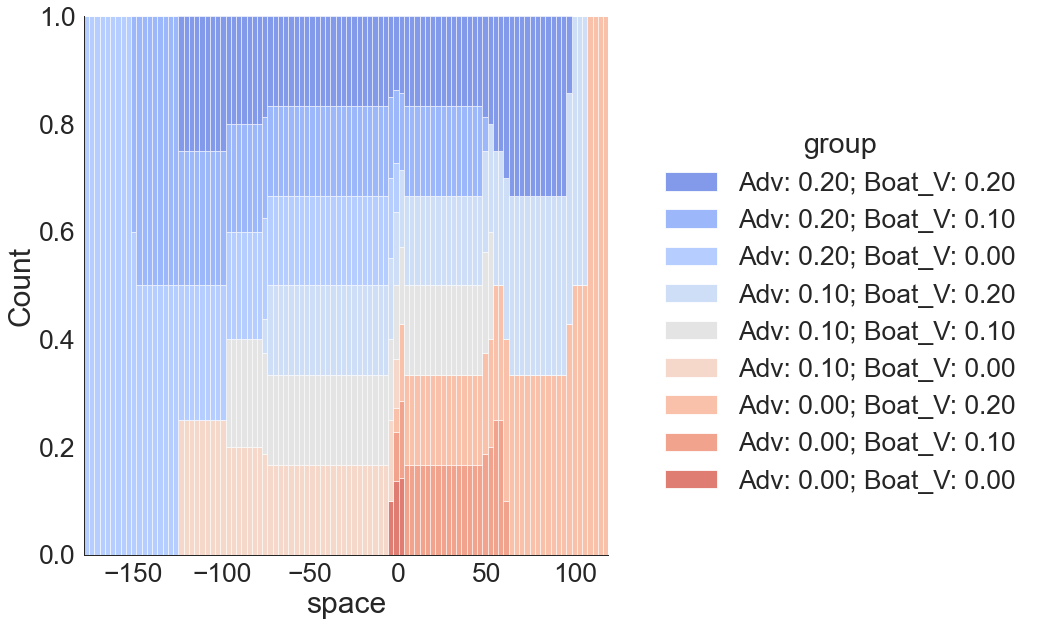

In [115]:
sns.displot( data = lg.explode('space'), x= 'space', hue = 'group',multiple="fill", height = 10, palette="coolwarm", bins = 100)

In [218]:
bv_space

array([1.0000e-04, 2.5005e-01, 5.0000e-01])

Text(0.5, 112.55999999999997, 'River Velocity (m/s)')

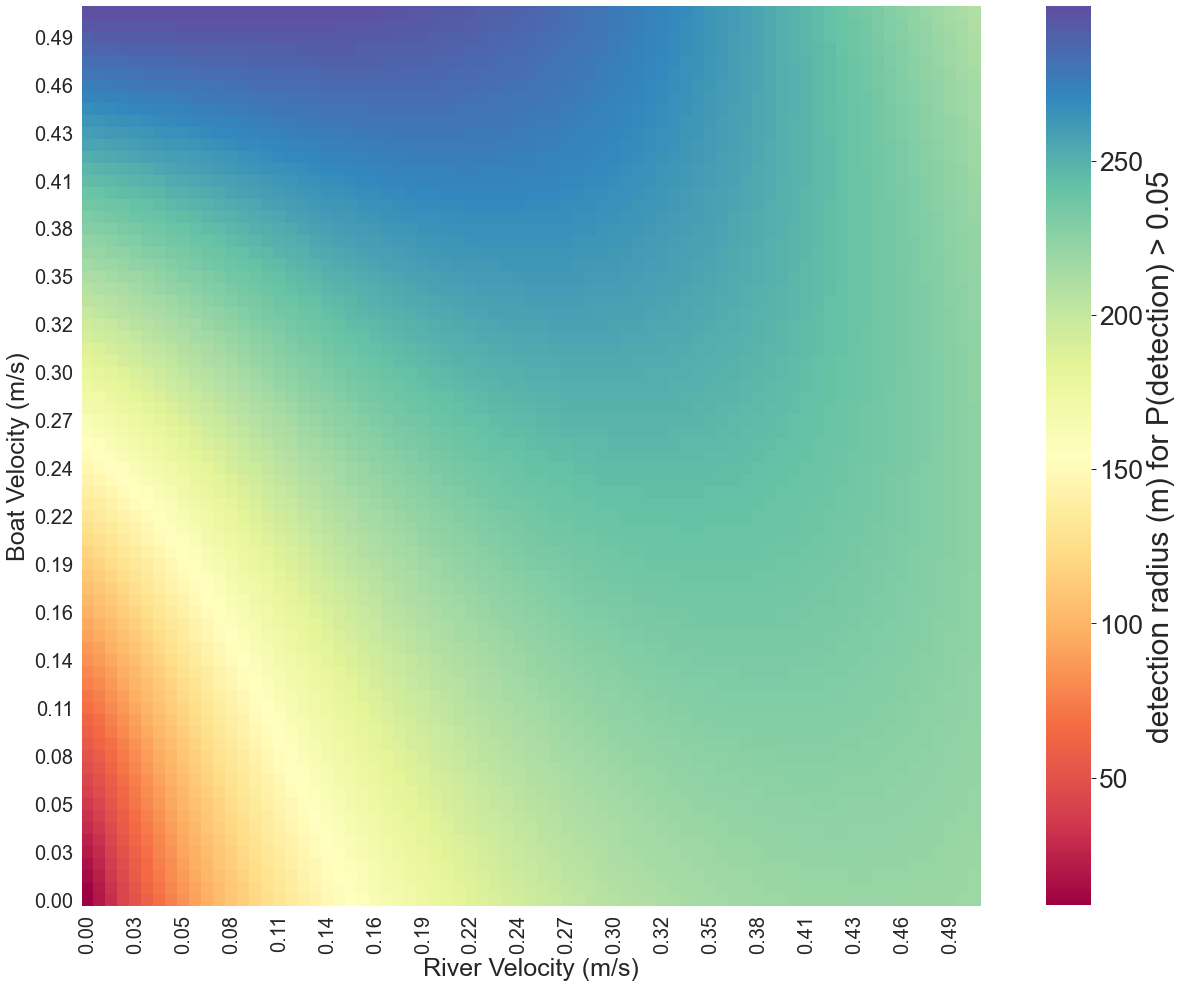

In [142]:
#sns.set(font_scale=2)
a = sns.heatmap(lg[['Boat speed', 'Advection', 'length']].pivot('Boat speed', 'Advection'), cmap = 'Spectral',  
            xticklabels = [ "{:.2f}".format(y) if x  % 4 ==0 else '' for x, y in enumerate(rivV_space)],
            yticklabels = [ "{:.2f}".format(y) if x  % 4 ==0 else '' for x, y in enumerate(bv_space)],
            cbar_kws={'label': 'detection radius (m) for P(detection) > 0.05'}, #  effective sampled length (m) 
            square = 1 )


plt.xticks(fontsize = 20)
a.invert_yaxis()
plt.yticks(fontsize = 20)
#plt.xlim([0,rivV_space[-1]])
#plt.ylim([0,bv_space[-1]])

plt.ylabel("Boat Velocity (m/s)",fontsize = 25)
plt.xlabel("River Velocity (m/s)",fontsize = 25)

In [119]:
def Find_detection_range(p):
    max_up = optimize.bisect(lambda d: river.CtoP(river._sld_intermediary(-d, -d+river.BV*river.T))[0] - p, 0, 1e10)
    max_down = optimize.bisect(lambda d: river.CtoP(river._sld_intermediary(-d, -d+river.BV*river.T))[0] - p, -1e10, 0)
    return sorted([max_down, max_up])

In [88]:
optimize.bisect(lambda d: river.CtoP(river._sld_intermediary(-d, -d+river.BV*river.T))[0] - 0.05, -1e10, 0)

-45.02809882649988

In [124]:
Find_detection_range(0.05)

[-55.58676163932341, 68.78681331873912]

In [92]:
river.V

0.50005

In [55]:
river.CtoP(river._sld_intermediary(10, 11))

array([0.0680736])

In [61]:
river.CtoP(river._sld_intermediary(0, river.BV*river.T))

array([1.])

In [38]:
river.sample_eDNA_transect(0)

500.06703778677206

In [39]:
river.sample_eDNA_transect(1)

499.7776630345827